In [2]:
import os
import multiprocessing
import json
import re
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
import string
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import stanza
from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stanza.download('en')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanbe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanbe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tanbe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


2024-11-04 11:29:12 INFO: Downloaded file to C:\Users\tanbe\stanza_resources\resources.json
2024-11-04 11:29:12 INFO: Downloading default packages for language: en (English) ...
2024-11-04 11:29:14 INFO: File exists: C:\Users\tanbe\stanza_resources\en\default.zip
2024-11-04 11:29:19 INFO: Finished downloading models and saved to C:\Users\tanbe\stanza_resources


## attempt at Bulgarian analysis 

In [3]:
class BulgarianTextAnalyzer:
    def __init__(self):
        # Manually defined list of Bulgarian stopwords
        self.stopwords = set([
            "и", "в", "на", "с", "за", "но", "като", "от", "към", "не", "е", "да", 
            "това", "мога", "бях", "ще", "кой", "която", "как", "какво", "както",
            "все", "чрез", "въпреки", "всички", "последствия", "по", "така", "защото"
        ])

    def clean_text(self, text):
        """Basic cleaning: remove punctuation and lowercase the text."""
        text = text.lower()  # Lowercase the text
        text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
        return text

    def get_word_count(self, text):
        """Calculate the total word count."""
        words = nltk.word_tokenize(text)
        return len(words)

    def get_sentence_count(self, text):
        """Calculate the total sentence count."""
        sentences = nltk.sent_tokenize(text)
        return len(sentences)

    def get_most_frequent_words(self, texts):
        """Aggregate words from all texts and find the most frequent words."""
        all_words = []
        for text in texts:
            # Tokenize words, filter out stopwords, and keep only alphabetic words
            words = [word for word in nltk.word_tokenize(text) if word.isalpha() and word not in self.stopwords]
            all_words.extend(words)
        word_freq = Counter(all_words)
        return word_freq.most_common()

    def analyze_directory(self, directory_path):
        """Analyze all text files in a specified directory and return aggregated results."""
        texts = []
        total_word_count = 0
        total_sentence_count = 0
        
        for filename in os.listdir(directory_path):
            if filename.endswith(".txt"):
                filepath = os.path.join(directory_path, filename)
                with open(filepath, 'r', encoding='utf-8') as file:
                    text = file.read()
                    cleaned_text = self.clean_text(text)
                    texts.append(cleaned_text)
                    total_word_count += self.get_word_count(cleaned_text)
                    total_sentence_count += self.get_sentence_count(cleaned_text)

        most_frequent_words = self.get_most_frequent_words(texts)
        
        # Print the aggregated analysis
        print(f"Total Words Across All Files: {total_word_count}")
        print(f"Total Sentences Across All Files: {total_sentence_count}")
        
        # Create a plot for the most frequent words
        self.plot_most_frequent_words(most_frequent_words)

    def plot_most_frequent_words(self, most_frequent_words, n=20):
        """Plot the n most frequent words."""
        words, frequencies = zip(*most_frequent_words[:n])
        
        plt.figure(figsize=(10, 6))
        plt.bar(words, frequencies, color='skyblue')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.title('Most Frequent Words in Bulgarian Texts')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


Total Words Across All Files: 63865
Total Sentences Across All Files: 211


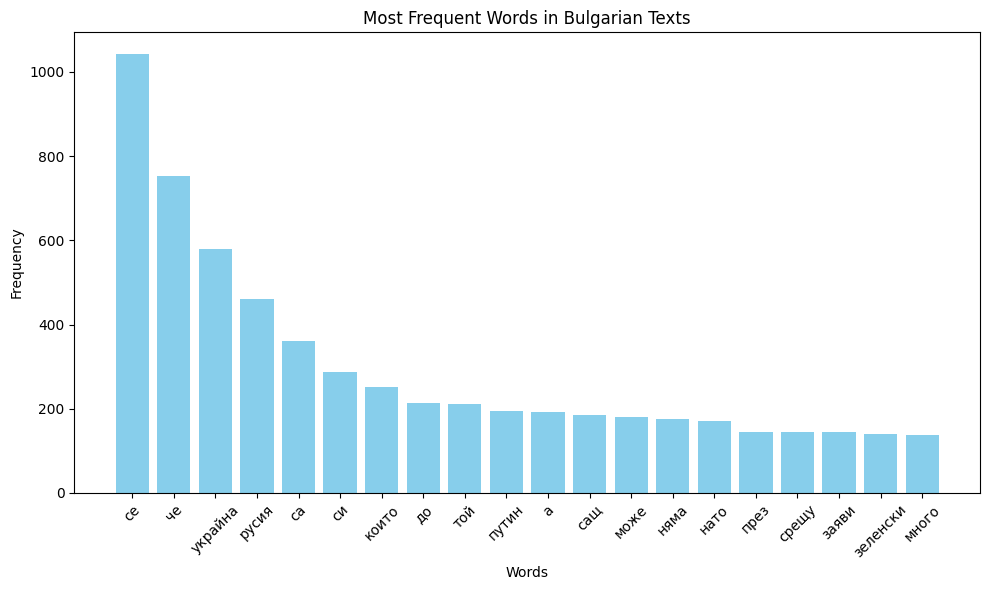

In [4]:
directory_path = 'C:/Users/tanbe/nlp_narrative_classification/data/BG/raw-documents'  
analyzer = BulgarianTextAnalyzer()
analyzer.analyze_directory(directory_path)

## Translated text analysis

There are no clear file types, but climate change text is only found in files without a9.

In [5]:
class WordFrequencyAnalyzer:
    def __init__(self):          
        # Get stopwords from NLTK
        self.nltk_stopwords = set(stopwords.words('english'))
        
        # Additional common words to filter
        self.additional_stopwords = {
            'said', 'would', 'could', 'also', 'one', 'two', 'three',
            'first', 'second', 'third', 'new', 'time', 'many', 'much',
            'may', 'might', 'must', 'like', 'well'
        }
        
        self.all_stopwords = self.nltk_stopwords.union(self.additional_stopwords)

    def process_file(self, file_path):
        """Process a single file and return word frequencies with and without stopwords."""
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read().lower()  # Convert to lowercase
            
            # NLTK tokenization
            tokens = word_tokenize(text)
            
            # Remove punctuation and numbers
            words = [word for word in tokens if word.isalpha()]
            
            # Create two frequency distributions
            freq_with_stops = Counter(words)
            freq_without_stops = Counter(
                word for word in words if word not in self.all_stopwords
            )
            
            return {
                'with_stops': freq_with_stops,
                'without_stops': freq_without_stops,
                'total_words': len(words)
            }
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None

    def analyze_directory(self, data_dir: str):
        """Analyze all text files in the directory."""
        data_path = Path(data_dir)
        if not data_path.exists():
            raise FileNotFoundError(f"Directory not found: {data_path}")

        # Initialize counters for different file types
        propaganda_frequencies = {'with_stops': Counter(), 'without_stops': Counter()}
        climate_frequencies = {'with_stops': Counter(), 'without_stops': Counter()}
        
        # Statistics
        stats = {
            'Propaganda': {'files': 0, 'total_words': 0},
            'Climate': {'files': 0, 'total_words': 0}
        }

        # Process each file
        for file_path in data_path.glob('*.txt'):
            results = self.process_file(file_path)
            if results:
                # Determine file type
                filename = file_path.name
                if 'A9' in filename:
                    file_type = 'Propaganda'
                    target_freq = propaganda_frequencies
                else:
                    file_type = 'Climate'
                    target_freq = climate_frequencies

                # Update statistics
                stats[file_type]['files'] += 1
                stats[file_type]['total_words'] += results['total_words']
                
                # Update frequencies
                target_freq['with_stops'].update(results['with_stops'])
                target_freq['without_stops'].update(results['without_stops'])

        # Create DataFrames for top 20 words
        def create_freq_df(counter: Counter, label: str):
            df = pd.DataFrame.from_records(
                counter.most_common(20),
                columns=['word', 'frequency']
            )
            df['source'] = label
            return df

        # Create separate DataFrames for Propaganda and Climate
        propaganda_with_stops = create_freq_df(propaganda_frequencies['with_stops'], 'Propaganda Files')
        propaganda_without_stops = create_freq_df(propaganda_frequencies['without_stops'], 'Propaganda Files')
        climate_with_stops = create_freq_df(climate_frequencies['with_stops'], 'Climate Files')
        climate_without_stops = create_freq_df(climate_frequencies['without_stops'], 'Climate Files')

        # Combine DataFrames
        with_stops_df = pd.concat([propaganda_with_stops, climate_with_stops])
        without_stops_df = pd.concat([propaganda_without_stops, climate_without_stops])

        return stats, with_stops_df, without_stops_df

    def plot_comparisons(self, with_stops_df: pd.DataFrame, without_stops_df: pd.DataFrame):
        """Create comparison plots for word frequencies."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

        # Plot frequencies with stopwords
        sns.barplot(data=with_stops_df, x='frequency', y='word', hue='source', ax=ax1)
        ax1.set_title('Top 20 Words (Including Stopwords)')
        ax1.set_xlabel('Frequency')
        ax1.set_ylabel('Word')

        # Plot frequencies without stopwords
        sns.barplot(data=without_stops_df, x='frequency', y='word', hue='source', ax=ax2)
        ax2.set_title('Top 20 Words (Excluding Stopwords)')
        ax2.set_xlabel('Frequency')
        ax2.set_ylabel('Word')

        plt.tight_layout()
        plt.show()



File Statistics:

Propaganda Files:
Number of files: 70
Total words processed: 17,229

Climate Files:
Number of files: 141
Total words processed: 47,610


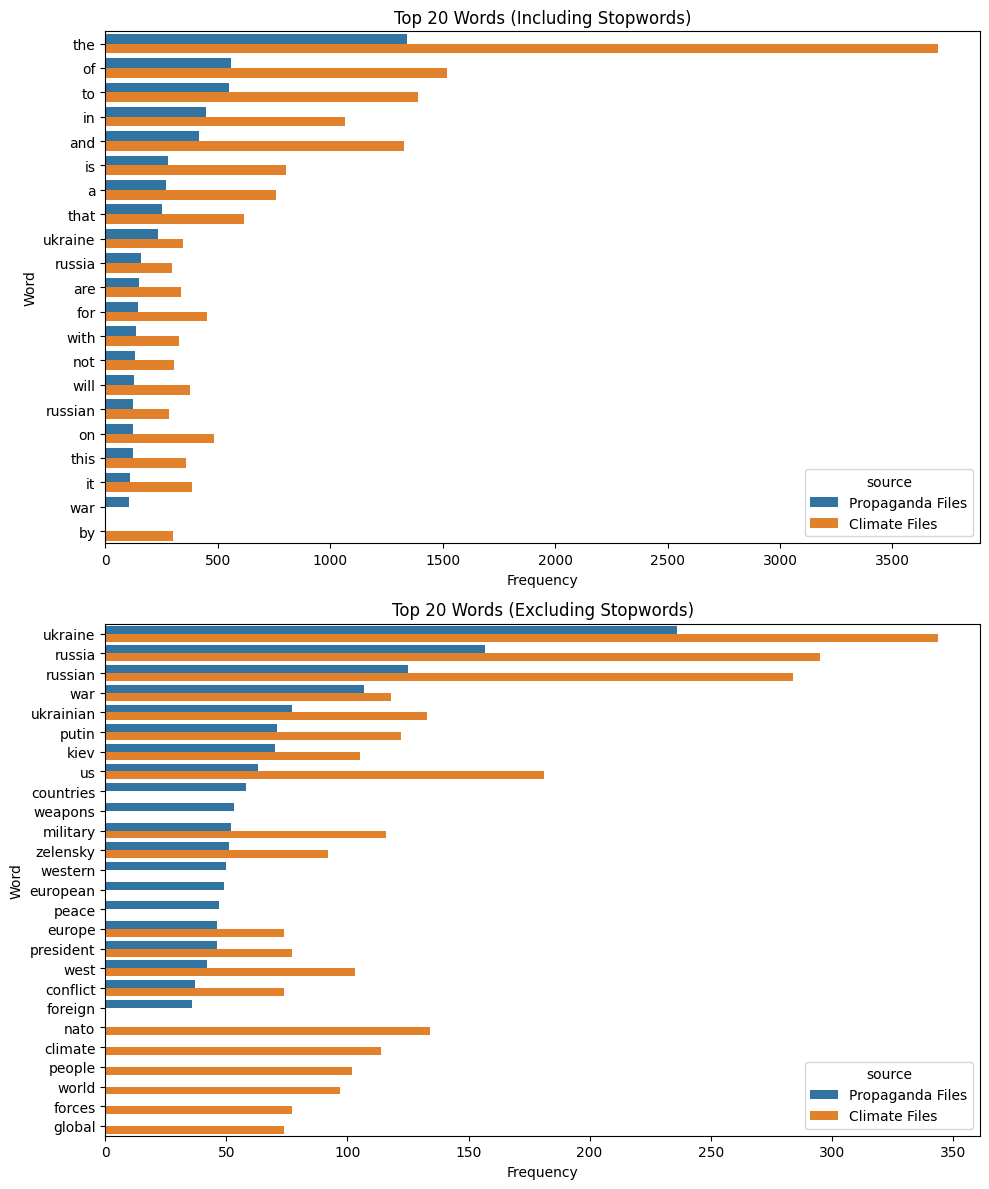

In [6]:
analyzer = WordFrequencyAnalyzer()
data_dir = 'C:/Users/tanbe/nlp_narrative_classification/data/BG/translated-documents'  
stats, with_stops_df, without_stops_df = analyzer.analyze_directory(data_dir)

# Print statistics
print("\nFile Statistics:")
for file_type, file_stats in stats.items():
    print(f"\n{file_type} Files:")
    print(f"Number of files: {file_stats['files']}")
    print(f"Total words processed: {file_stats['total_words']:,}")

# Create visualizations
analyzer.plot_comparisons(with_stops_df, without_stops_df)

### Irrelevant words to remove

In [17]:
class BoilerplateAnalyzer:
    def __init__(self):
        # Common boilerplate patterns to search for
        self.boilerplate_patterns = {
            'read_more': r"read more|continue reading|published on|copyright|source: \[.*\]",  # usually points to external content, discard line
            'non_content': r"conclusion|summary|introduction|methods|results|references",  # common sections in academic writing, discard line
            'academic_phrases': r"this study focuses on|the aim of this study is|the data suggests|the implications of this study",  # frequent phrases that may not add unique insights, discard line
            'political_party': r"leader of [^\s]+|supporters of [^\s]+",  # mentions of political affiliations, not substantive to the argument, discard line
            'calls_to_action': r"stop all arms and money deliveries|endless war|peace talks|#Peace|#StopNATO",  # emotive calls that may clutter the discourse, discard line
            'statements_of_opinion': r"we need to stop|it is necessary to|this policy must change|the time for action is now",  # expressions of opinion that do not contribute new insights, discard line
            'predictions': r"risk of WWIII|escalation of conflict|impact on international relations|threat to global security",  # speculative claims that clutter the content, discard line
            'political_jargon': r"military support|foreign policy|diplomatic efforts|geopolitical interests",  # jargon that may not add value, discard line
            'publish_date': r'published on',  # typically short and not informative, discard line
            'watch_more': r'watch more|watch the full|must watch',  # typically short and not informative, discard line
            'find_out_more': r'find out more|continue at [a-z].[a-z]{1,3}',  # usually a short line, discard line
            'social_media': r'twitter|instagram|facebook|telegram',  # handles social media mentions case by case
            'news_company': r'[A-Z][a-z]+(?: [A-Z][a-z]+)* News',  # identifies news organizations, which may not be informative
            'press_company': r'[A-Z][a-z]+(?: [A-Z][a-z]+)* Press',  # identifies press organizations, may not add value
            'about_the_writer': r'about the writer',  # no useful content follows this
            'urls': r'https?:\/\/[^\s]+',  # usually a short line, discard line
            'journalist': r"[Bb]y (?:[A-Z][a-zA-Z\-']+ [A-Z][a-zA-Z\-']+, [A-Z][a-zA-Z\s]+ News:|[A-Z][a-zA-Z\-']+ [A-Z][a-zA-Z\-']+ of [A-Z][a-zA-Z\s]+ News)",
            'make_donation': r"make a donation|donation buttons",  # usually a short line, discard line
            'headlines': r"^(.*\n)",
            'header_footer': r"read more|published on|source: \[.*\]",  # administrative details, usually discard
            'literature_citations': r"according to [^\s]+ \(.*\)|as shown in previous studies",  # repeated literature references, may not add new insights, discard line
            'technical_terms': r"anthropogenic|greenhouse gases|paleoclimate data",  # technical terms can dilute focus, discard line
            'repetitive_phrasing': r"this is not the time|we cannot allow",  # commonly repeated phrases that do not advance arguments, discard line
            'historical_context': r"historically speaking|in past conflicts",  # context that may not be directly relevant to current discussions, discard line
            'appeals_to_emotion': r"we must protect our children|the suffering must end",  # emotional language that may distract from core issues, discard line
}
        
        # Compile patterns for efficiency
        self.compiled_patterns = {
            name: re.compile(pattern, re.IGNORECASE) if '[A-Z]' not in pattern else re.compile(pattern)
            for name, pattern in self.boilerplate_patterns.items()
        }

    def analyze_file(self, file_path: Path):
        """Analyze a single file for boilerplate patterns."""
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()

            results = {
                'filename': file_path.name,
                'total_lines': len(content.splitlines()),
                'total_chars': len(content),
                'matches': defaultdict(list)
            }

            # Find all matches for each pattern
            for name, pattern in self.compiled_patterns.items():
                matches = pattern.finditer(content)
                for match in matches:
                    results['matches'][name].append({
                        'text': match.group().strip(),
                        'position': match.start()
                    })

            return results
        
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None

    def analyze_directory(self, data_dir: str):
        """Analyze all text files in the directory."""
        data_path = Path(data_dir)
        if not data_path.exists():
            raise FileNotFoundError(f"Directory not found: {data_path}")

        all_results = []
        total_stats = defaultdict(int)
        pattern_locations = defaultdict(list)
        
        # Process each file
        for file_path in data_path.glob('*.txt'):
            results = self.analyze_file(file_path)
            if results:
                all_results.append(results)
                
                # Update total statistics
                total_stats['total_files'] += 1
                total_stats['total_lines'] += results['total_lines']
                total_stats['total_chars'] += results['total_chars']
                
                # Count pattern matches
                for pattern_name, matches in results['matches'].items():
                    total_stats[f'{pattern_name}_count'] += len(matches)
                    for match in matches:
                        pattern_locations[pattern_name].append(
                            match['position'] / results['total_chars']  # Normalize position
                    )
        
        # Create summary DataFrame
        summary_data = []
        for pattern_name in self.boilerplate_patterns.keys():
            count = total_stats.get(f'{pattern_name}_count', 0)
            avg_position = (
                sum(pattern_locations[pattern_name]) / len(pattern_locations[pattern_name])
                if pattern_locations[pattern_name] else 0
            )
            
            summary_data.append({
                'pattern': pattern_name,
                'total_occurrences': count,
                'files_percentage': (count / total_stats['total_files'] * 100) if total_stats['total_files'] > 0 else 0,
                'avg_relative_position': avg_position
            })

        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('total_occurrences', ascending=False)

        return summary_df, total_stats

    def plot_statistics(self, summary_df, total_stats):
        """Plot analysis results."""
        plt.figure(figsize=(8, 5))
        plt.barh(summary_df['pattern'], summary_df['files_percentage'])
        plt.title('Percentage of Files Containing Each Boilerplate Pattern')
        plt.xlabel('Percentage of Files (%)')
        plt.ylabel('Pattern Type')
        plt.tight_layout()
        plt.show()
        


Overall Statistics:
Total files analyzed: 211
Total lines processed: 2,145
Total characters processed: 407,013

Boilerplate Pattern Summary:


,pattern,total_occurrences,files_percentage,avg_relative_position
18,headlines,211,100.000000,0.000000
1,non_content,28,13.270142,0.489315
7,political_jargon,21,9.952607,0.585127
4,calls_to_action,21,9.952607,0.381512
21,technical_terms,17,8.056872,0.538199
11,social_media,13,6.161137,0.367104
5,statements_of_opinion,11,5.213270,0.588128
15,urls,8,3.791469,0.761945
3,political_party,7,3.317536,0.421299
13,press_company,3,1.421801,0.315746


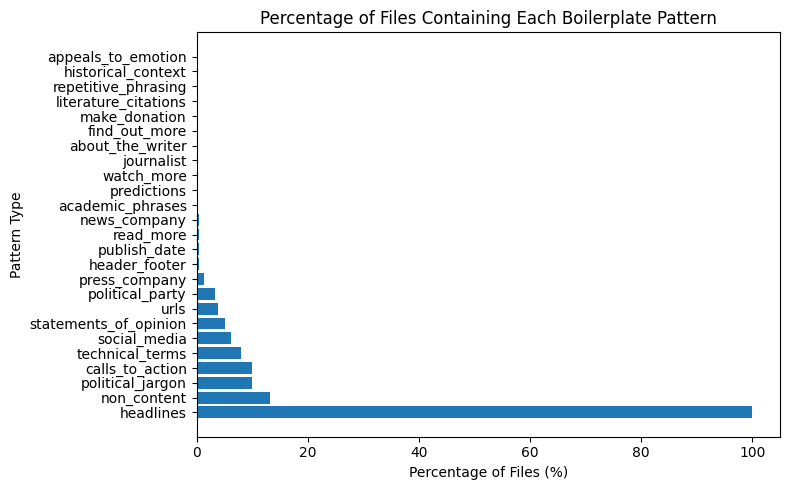

In [18]:
analyzer = BoilerplateAnalyzer()
data_dir = 'C:/Users/tanbe/nlp_narrative_classification/data/BG/translated-documents'
summary_df, total_stats = analyzer.analyze_directory(data_dir)

# Print statistics
print("\nOverall Statistics:")
print(f"Total files analyzed: {total_stats['total_files']}")
print(f"Total lines processed: {total_stats['total_lines']:,}")
print(f"Total characters processed: {total_stats['total_chars']:,}")

# Display summary DataFrame
print("\nBoilerplate Pattern Summary:")
display(summary_df)

# Plot results
analyzer.plot_statistics(summary_df, total_stats)

### Text segmentation and normalizaton

In [14]:
nlp = stanza.Pipeline('en', processors='tokenize,lemma,pos')

2024-11-04 04:26:58 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-11-04 04:26:58 INFO: Downloaded file to C:\Users\tanbe\stanza_resources\resources.json
2024-11-04 04:26:58 WARNING: Language en package default expects mwt, which has been added
2024-11-04 04:26:59 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2024-11-04 04:26:59 INFO: Using device: cpu
2024-11-04 04:26:59 INFO: Loading: tokenize
c:\Users\tanbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\stanza\models\tokenization\trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mor

In [15]:

class TextAnalyzer:
    def __init__(self):
        self.summary = []

    def analyze_file(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        
        doc = nlp(text)
        total_lines = text.count('\n') + 1
        total_chars = len(text)
        total_sentences = len(doc.sentences)
        words = [word.lemma for sentence in doc.sentences for word in sentence.words]
        
        total_words = len(words)
        unique_words = len(set(words))
        stemmed_words = len(set(word.text for sentence in doc.sentences for word in sentence.words))  # Placeholder for stemming
        lemmatized_words = unique_words

        return {
            'file_name': os.path.basename(file_path),
            'total_lines': total_lines,
            'total_chars': total_chars,
            'total_sentences': total_sentences,
            'total_words': total_words,
            'unique_words': unique_words,
            'stemmed_words': stemmed_words,
            'lemmatized_words': lemmatized_words
        }

    def analyze_single_file(self, file_path):
        # Analyze a single file instead of a directory
        self.summary = [self.analyze_file(file_path)]
        summary_df = pd.DataFrame(self.summary)
        
        total_stats = {
            'total_files': len(self.summary),
            'total_lines': summary_df['total_lines'].sum(),
            'total_chars': summary_df['total_chars'].sum()
        }

        return summary_df, total_stats

    def plot_statistics(self, summary_df, total_stats):
        summary_df.set_index('file_name', inplace=True)
        summary_df[['unique_words', 'stemmed_words', 'lemmatized_words']].plot(kind='bar', figsize=(12, 6))
        plt.title('Comparison of Unique, Stemmed, and Lemmatized Words')
        plt.ylabel('Count')
        plt.xlabel('File Name')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [19]:
file_path = 'C:/Users/tanbe/nlp_narrative_classification/data/BG/translated-documents/A9_BG_2566.txt'

with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

print("Original Text:")
print(text)
print("\n--- Tokenization ---")
doc = nlp(text)
tokens = [word.text for sentence in doc.sentences for word in sentence.words]
print("Tokens:", tokens)

print("\n--- Lemmatization ---")
lemmas = [word.lemma for sentence in doc.sentences for word in sentence.words]
print("Lemmas:", lemmas)

print("\n--- Original Words with Lemmas ---")
for token, lemma in zip(tokens, lemmas):
    print(f"{token} -> {lemma}")

Original Text:
Lavrov: Baltic countries provoke Russophobia in EU and NATO

According to Russian Foreign Minister Sergey Lavrov, the revival and manifestation of Nazism in the countries of Europe began after Lithuania, Latvia and Estonia joined the EU and NATO.
The revival and manifestation of Nazism in the countries of Europe began after Lithuania, Latvia and Estonia joined the European Union and NATO. Russian Foreign Minister Sergei Lavrov reported this in an interview with the "No Limitation" project.
"If we now look at the situation in NATO and the EU, the Baltic states, together with the Poles and the Czechs, are the most aggressive group in the European structures. These countries are among those who initiate the most Russophobic positions and actions of the EU and the North Atlantic Alliance," he noted.
In addition, the Russian diplomat recalled that the Baltic countries, joining the "civilized" European family, began to organize demonstrations, torchlight processions in honor o


Overall Statistics:
Total files analyzed: 1
Total lines processed: 7
Total characters processed: 1,340

Text Analysis Summary:
        file_name  total_lines  total_chars  total_sentences  total_words  \
0  A9_BG_2566.txt            7         1340                9          255   

   unique_words  stemmed_words  lemmatized_words  
0           115            124               115  


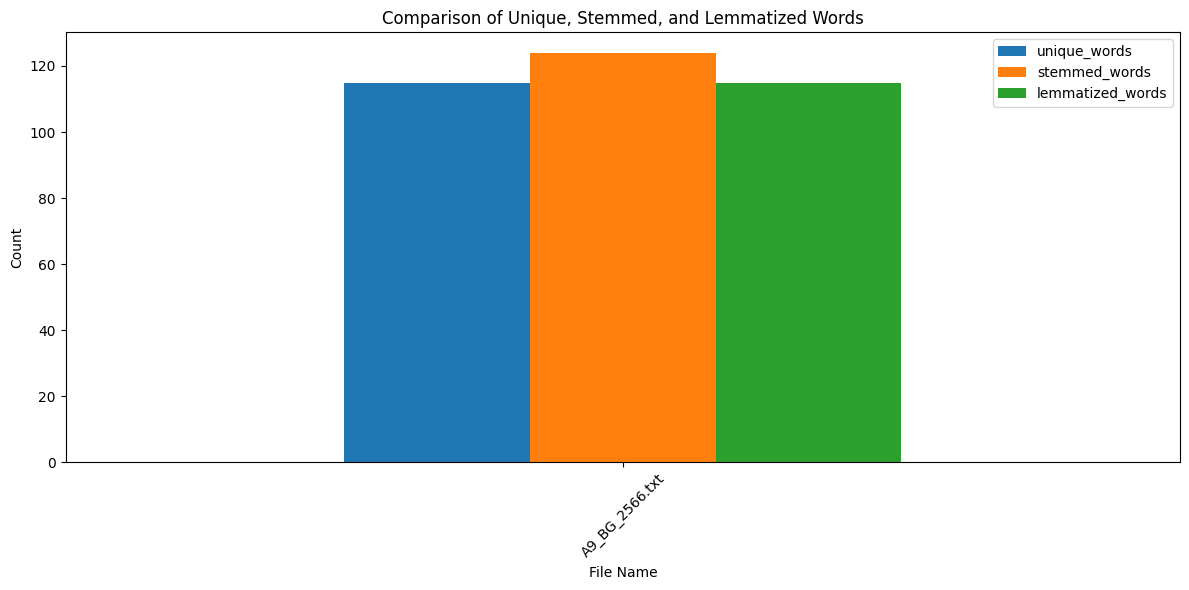

In [17]:
analyzer = TextAnalyzer()
summary_df, total_stats = analyzer.analyze_single_file(file_path)

# Print statistics
print("\nOverall Statistics:")
print(f"Total files analyzed: {total_stats['total_files']}")
print(f"Total lines processed: {total_stats['total_lines']:,}")
print(f"Total characters processed: {total_stats['total_chars']:,}")

# Display summary DataFrame
print("\nText Analysis Summary:")
print(summary_df)

analyzer.plot_statistics(summary_df, total_stats)